# Clustering

## Data loading and preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# from google.colab import drive
# drive.mount('/content/drive')
# file_prefix = '/content/drive/MyDrive/DP/analysis/outlier_detection/'

file_prefix = 'tmp/'

In [2]:
# load data
df_names = ['2020-01', '2020-02']
dfs = {}

for name in df_names:
    df = pd.read_csv(f'{file_prefix}{name}.csv', dtype={'STK': 'object'}, index_col=0)
    df['DatKont'] = pd.to_datetime(df['DatKont'])
    df['DatPrvReg'] = pd.to_datetime(df['DatPrvReg'])
    dfs[name] = df

### Basic transformations

In [3]:
for name, df in dfs.items():
    # drop unneeded columns
    # - TypMot (while we don't have more info)
    # - VyslEmise
    df = df.drop(['TypMot', 'VyslEmise'], axis=1)

    # drop irrelevant rows
    # - DrTP other than "evidencni" and "pravidelna"
    # - DrVoz other than "osobni" and "nakladni"
    df = df[
        ((df['DrTP'] == 'Evidenční kontrola') | (df['DrTP'] == 'pravidelná'))
        &
        ((df['DrVoz'] == 'OSOBNÍ AUTOMOBIL') | (df['DrVoz'] == 'NÁKLADNÍ AUTOMOBIL'))]
    
    # drop rows with nan `DatPrvReg`
    df = df.dropna(subset=['DatPrvReg', 'StariDnu'])

    # transform to numerical features only
    def stk_result_to_ordinal(text):
        if text == 'způsobilé':
            return 0
        if text == 'částečně způsobilé':
            return 1
        if text == 'nezpůsobilé':
            return 2
        return 3
    df['VyslSTK'] = df['VyslSTK'].apply(stk_result_to_ordinal).astype('uint8')

    dfs[name] = df


### Split by specific indentifiers
To avoid having to encode them as dummies and because a fleet should not span across these groups.
- STK
- DrTP
- DrVoz
- TZn

We only save groups with at least 3 items - a fleet should have at least 3 vehicles.

In [4]:
df_groups = {}
all_group_sizes = []
selected_group_sizes = []

for name, df in dfs.items():
    gb = df.groupby(['STK', 'DrTP', 'DrVoz', 'TZn'])
    for group in gb.groups:
        df_group = gb.get_group(group)
        
        if group not in df_groups.keys():
            df_groups[group] = {}

        df_groups[group][name] = df_group
        selected_group_sizes.append(len(df_group))
        
        all_group_sizes.append(len(df_group))

In [5]:
np.histogram(all_group_sizes, bins=100)

(array([40169,  5880,  2420,  1360,   763,   529,   302,   211,   127,
          122,    82,    72,    57,    42,    60,    50,    43,    44,
           23,    33,    23,    32,    24,    30,    29,    31,    15,
           10,    21,    16,     9,     9,     8,    13,     5,     6,
            9,     8,     6,     4,     1,     6,     6,     2,     2,
            3,     0,     3,     1,     0,     3,     1,     0,     0,
            0,     0,     1,     0,     0,     2,     1,     0,     1,
            0,     0,     0,     1,     0,     1,     1,     0,     0,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     1,     0,     0,     0,     0,     0,     0,
            1]),
 array([  1.  ,   8.19,  15.38,  22.57,  29.76,  36.95,  44.14,  51.33,
         58.52,  65.71,  72.9 ,  80.09,  87.28,  94.47, 101.66, 108.85,
        116.04, 123.23, 130.42, 137.61, 144.8 , 151.99, 15

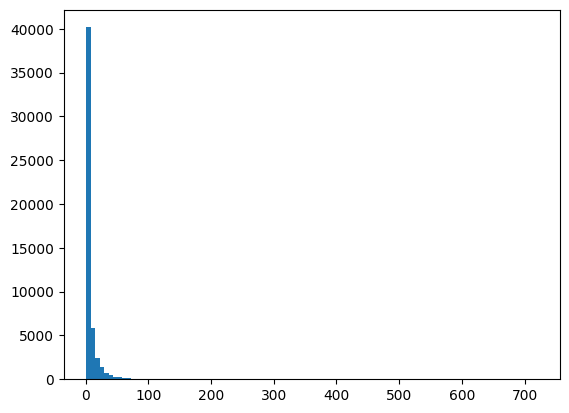

In [6]:
plt.hist(all_group_sizes, bins=100)
plt.show()

### Split to sliding window intervals
Size ~14 days, step ~7 days, depeding on month lenght.

Periods by date:
- 1-14
- 8-21
- 15-end of month
- 22-7 of the next month if available

In [7]:
df_grouped_time_windows = {}

for group, groupdata in df_groups.items():

    time_windows = []

    # construct time windows with overlapping months (= by name)
    had_prev_month = False
    for name_index, name in enumerate(df_names):
        # if we dont have data for the current month, skip it and signal a gap
        if name not in groupdata.keys():
            had_prev_month = False
            continue
        
        df = groupdata[name]
        
        if had_prev_month:
            # construct an overlap with the previous month
            
            prev_df = groupdata[df_names[name_index - 1]]
            start_ts = np.datetime64(df_names[name_index - 1] + '-22')
            end_ts = np.datetime64(name + '-07')
            
            # create the interval
            first = prev_df[prev_df['DatKont'] >= start_ts]
            second = df[df['DatKont'] <= end_ts]

            interval = pd.concat([first, second]).copy(deep=True)

            if len(interval) >= 3:
                # transform date to days since the start of the interval
                interval.loc[:, 'RelKont'] = (interval['DatKont'] - start_ts).astype('timedelta64[D]')
                # add interval to the list of time windows
                time_windows.append(interval)
        
        # get each ~14 day period in this month
        start_day = 1
        while start_day <= 15:
            start_ts = np.datetime64(name + '-' + str(start_day).zfill(2))
            interval = None

            # create the interval
            if start_day == 15:
                interval = df[df['DatKont'] >= start_ts].copy(deep=True)
            else:
                end_ts = np.datetime64(name + '-' + str(start_day + 13).zfill(2))
                interval = df[(df['DatKont'] >= start_ts) & (df['DatKont'] <= end_ts)].copy(deep=True)

            if len(interval) >= 3:
                # transform date to days since the start of the interval
                interval.loc[:, 'RelKont'] = (interval['DatKont'] - start_ts).astype('timedelta64[D]')
                # add interval to the list of time windows
                time_windows.append(interval)

            # step
            start_day = start_day + 7

        had_prev_month = True

    df_grouped_time_windows[group] = time_windows

In [8]:
for group, tw in df_grouped_time_windows.items():
    print(group)
    if not tw:
        continue
    display(tw[0].head())
    print(tw[0].columns)
    
    break

('3100', 'Evidenční kontrola', 'NÁKLADNÍ AUTOMOBIL', 'AUDI')
('3100', 'Evidenční kontrola', 'NÁKLADNÍ AUTOMOBIL', 'CITROËN')


,STK,DrTP,VIN,DatKont,TZn,DrVoz,ObchOznTyp,Ct,DatPrvReg,Km,...,Zav2,Zav3,Zav4,Zav5,Zav6,Zav7,Zav8,Zav9,StariDnu,RelKont
87697,3100,Evidenční kontrola,VF7YCTMFC12637322,2020-01-10,CITROËN,NÁKLADNÍ AUTOMOBIL,JUMPER,N1,2014-06-24,165933,...,0,0,0,0,0,0,0,0,3123.0,2.0
135853,3100,Evidenční kontrola,VF7GJRHYK93203114,2020-01-15,CITROËN,NÁKLADNÍ AUTOMOBIL,BERLINGO (G),N1,2005-04-05,176547,...,0,0,0,0,0,0,0,0,6490.0,7.0
195539,3100,Evidenční kontrola,VF7GC9HWC94367525,2020-01-21,CITROËN,NÁKLADNÍ AUTOMOBIL,BERLINGO,N1,2007-10-16,300904,...,0,0,0,0,0,0,0,0,5566.0,13.0


Index(['STK', 'DrTP', 'VIN', 'DatKont', 'TZn', 'DrVoz', 'ObchOznTyp', 'Ct',
       'DatPrvReg', 'Km', 'Zavady', 'VyslSTK', 'DTKont', 'ZavA', 'ZavB',
       'ZavC', 'Zav0', 'Zav1', 'Zav2', 'Zav3', 'Zav4', 'Zav5', 'Zav6', 'Zav7',
       'Zav8', 'Zav9', 'StariDnu', 'RelKont'],
      dtype='object')


## PCA + DBSCAN
PCA performed on individual time windows for better projection accuracy.

In [9]:
# pca

pca_transformed_df_grouped_time_windows = {}

scaler = StandardScaler()
pca = PCA(n_components=3, random_state=46845841)

for group, time_windows in df_grouped_time_windows.items():
    transformed_time_windows = []

    for time_window in time_windows:

        # smaller groups than 7 vehicles will be assessed using a handwritten heuristic
        if len(time_window) < 7:
            continue

        # drop unneeded features
        trans_df = time_window[['Km', 'VyslSTK', 'DTKont', 'ZavA', 'ZavB',
       'ZavC', 'Zav0', 'Zav1', 'Zav2', 'Zav3', 'Zav4', 'Zav5', 'Zav6', 'Zav7',
       'Zav8', 'Zav9', 'StariDnu', 'RelKont']]

        # convert `Ct` to dummies (is this feature needed?)
        # dummies = pd.get_dummies(trans_df[['Ct']], drop_first=True)
        # trans_df = pd.concat([trans_df, dummies], axis=1)

        # scale features
        trans_df = scaler.fit_transform(trans_df.to_numpy())
        trans_df = pd.DataFrame(trans_df, columns=['Km', 'VyslSTK', 'DTKont', 'ZavA', 'ZavB',
       'ZavC', 'Zav0', 'Zav1', 'Zav2', 'Zav3', 'Zav4', 'Zav5', 'Zav6', 'Zav7',
       'Zav8', 'Zav9', 'StariDnu', 'RelKont'])

        # transform using pca
        trans_df = pd.DataFrame(pca.fit_transform(trans_df))
        
        transformed_time_windows.append((time_window, trans_df.copy(deep=True)))

    pca_transformed_df_grouped_time_windows[group] = transformed_time_windows

"group ('3100', 'Evidenční kontrola', 'NÁKLADNÍ AUTOMOBIL', 'FORD')"

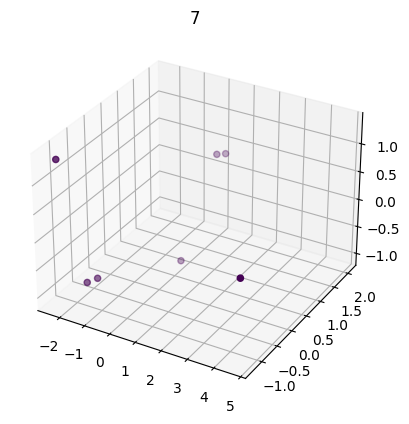

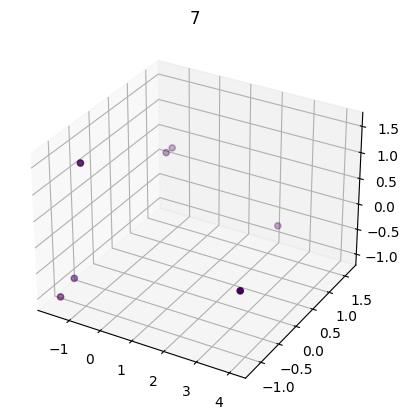

"group ('3100', 'Evidenční kontrola', 'NÁKLADNÍ AUTOMOBIL', 'IVECO')"

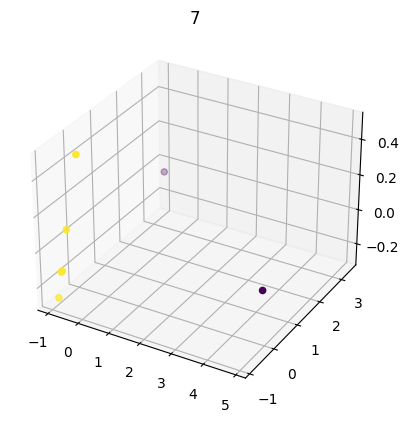

,0,STK,DrTP,VIN,DatKont,TZn,DrVoz,ObchOznTyp,Ct,DatPrvReg,...,Zav2,Zav3,Zav4,Zav5,Zav6,Zav7,Zav8,Zav9,StariDnu,RelKont
0,-1,3100,Evidenční kontrola,ZCFC50A2005672054,2020-02-11,IVECO,NÁKLADNÍ AUTOMOBIL,DAILY,N1,2007-10-01,...,0,0,0,0,0,0,0,0,5581.0,10.0
1,0,3100,Evidenční kontrola,ZCFC357160D538103,2020-02-12,IVECO,NÁKLADNÍ AUTOMOBIL,DAILY 35S11,N1,2014-11-12,...,0,0,0,0,0,0,0,0,2982.0,11.0
2,0,3100,Evidenční kontrola,ZCFC357160D538095,2020-02-12,IVECO,NÁKLADNÍ AUTOMOBIL,DAILY 35S11,N1,2014-11-12,...,0,0,0,0,0,0,0,0,2982.0,11.0
3,0,3100,Evidenční kontrola,ZCFC357160D538104,2020-02-12,IVECO,NÁKLADNÍ AUTOMOBIL,DAILY 35S11,N1,2014-10-30,...,0,0,0,0,0,0,0,0,2995.0,11.0
4,0,3100,Evidenční kontrola,ZCFC357160D538097,2020-02-12,IVECO,NÁKLADNÍ AUTOMOBIL,DAILY 35S11,N1,2014-10-09,...,0,0,0,0,0,0,0,0,3016.0,11.0
5,0,3100,Evidenční kontrola,ZCFC357160D538094,2020-02-12,IVECO,NÁKLADNÍ AUTOMOBIL,DAILY 35S11,N1,2014-10-09,...,0,0,0,0,0,0,0,0,3016.0,11.0
6,-1,3100,Evidenční kontrola,ZCFC35A8005755808,2020-02-13,IVECO,NÁKLADNÍ AUTOMOBIL,DAILY 35 C 15,N1,2008-09-03,...,0,0,0,0,0,0,0,0,5243.0,12.0


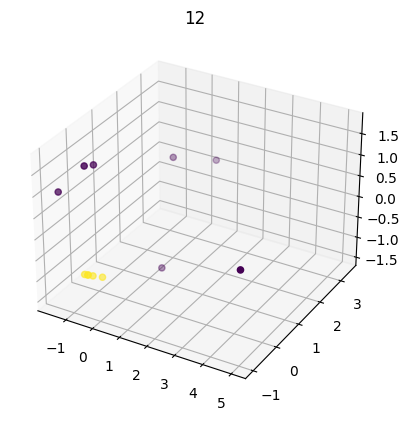

,0,STK,DrTP,VIN,DatKont,TZn,DrVoz,ObchOznTyp,Ct,DatPrvReg,...,Zav2,Zav3,Zav4,Zav5,Zav6,Zav7,Zav8,Zav9,StariDnu,RelKont
0,-1,3100,Evidenční kontrola,ZCFC50A2005672054,2020-02-11,IVECO,NÁKLADNÍ AUTOMOBIL,DAILY,N1,2007-10-01,...,0,0,0,0,0,0,0,0,5581.0,3.0
1,0,3100,Evidenční kontrola,ZCFC357160D538103,2020-02-12,IVECO,NÁKLADNÍ AUTOMOBIL,DAILY 35S11,N1,2014-11-12,...,0,0,0,0,0,0,0,0,2982.0,4.0
2,0,3100,Evidenční kontrola,ZCFC357160D538095,2020-02-12,IVECO,NÁKLADNÍ AUTOMOBIL,DAILY 35S11,N1,2014-11-12,...,0,0,0,0,0,0,0,0,2982.0,4.0
3,0,3100,Evidenční kontrola,ZCFC357160D538104,2020-02-12,IVECO,NÁKLADNÍ AUTOMOBIL,DAILY 35S11,N1,2014-10-30,...,0,0,0,0,0,0,0,0,2995.0,4.0
4,0,3100,Evidenční kontrola,ZCFC357160D538097,2020-02-12,IVECO,NÁKLADNÍ AUTOMOBIL,DAILY 35S11,N1,2014-10-09,...,0,0,0,0,0,0,0,0,3016.0,4.0
5,0,3100,Evidenční kontrola,ZCFC357160D538094,2020-02-12,IVECO,NÁKLADNÍ AUTOMOBIL,DAILY 35S11,N1,2014-10-09,...,0,0,0,0,0,0,0,0,3016.0,4.0
6,-1,3100,Evidenční kontrola,ZCFC35A8005755808,2020-02-13,IVECO,NÁKLADNÍ AUTOMOBIL,DAILY 35 C 15,N1,2008-09-03,...,0,0,0,0,0,0,0,0,5243.0,5.0
7,-1,3100,Evidenční kontrola,ZCFA75A0002250743,2020-02-17,IVECO,NÁKLADNÍ AUTOMOBIL,ML 75E14,N2,1998-02-05,...,0,0,0,0,0,0,0,0,9106.0,9.0
8,-1,3100,Evidenční kontrola,WJMJ3JPS10C068045,2020-02-17,IVECO,NÁKLADNÍ AUTOMOBIL,MP 340 E 35 HB,N3,1999-11-24,...,0,0,0,0,0,0,0,0,8449.0,9.0
9,-1,3100,Evidenční kontrola,ZCFC150B205269119,2020-02-18,IVECO,NÁKLADNÍ AUTOMOBIL,50C/35,N1,2019-12-12,...,0,0,0,0,0,0,0,0,1126.0,10.0


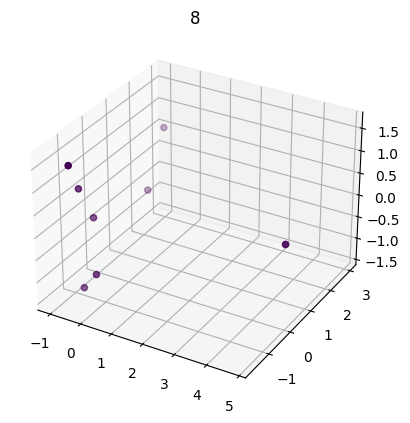

"group ('3100', 'Evidenční kontrola', 'NÁKLADNÍ AUTOMOBIL', 'MAN')"

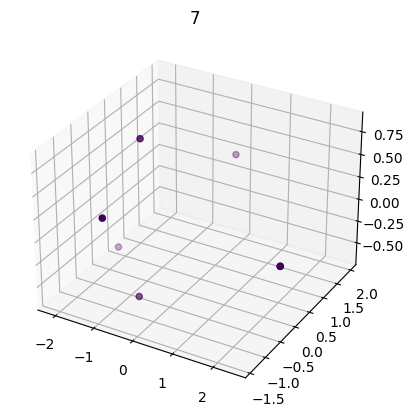

"group ('3100', 'Evidenční kontrola', 'NÁKLADNÍ AUTOMOBIL', 'MERCEDES-BENZ')"

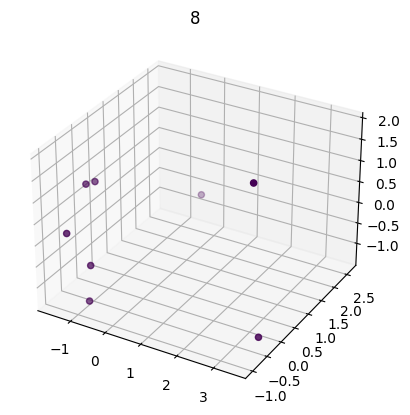

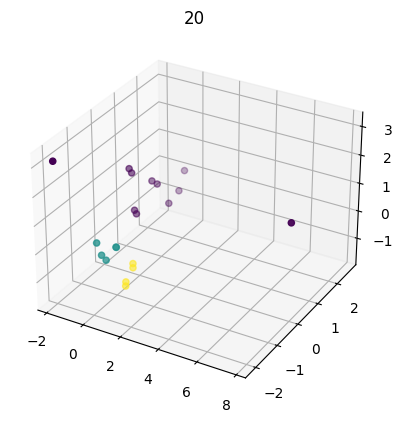

,0,STK,DrTP,VIN,DatKont,TZn,DrVoz,ObchOznTyp,Ct,DatPrvReg,...,Zav2,Zav3,Zav4,Zav5,Zav6,Zav7,Zav8,Zav9,StariDnu,RelKont
0,-1,3100,Evidenční kontrola,WDB96340310126943,2020-01-08,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,ACTROS,N3,2017-07-19,...,0,0,0,0,0,0,0,0,2002.0,0.0
1,-1,3100,Evidenční kontrola,WDB9066131P283555,2020-01-09,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,SPRINTER 210 CDI,N1,2016-05-20,...,0,0,0,0,0,0,0,0,2427.0,1.0
2,-1,3100,Evidenční kontrola,WDB9061351N612416,2020-01-14,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,SPRINTER,N1,2014-12-30,...,0,0,0,0,0,0,0,0,2934.0,6.0
3,-1,3100,Evidenční kontrola,WDB9061351N577261,2020-01-14,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,SPRINTER,N1,2014-02-17,...,0,0,0,0,0,0,0,0,3250.0,6.0
4,-1,3100,Evidenční kontrola,WDB9061311N376671,2020-01-15,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,SPRINTER,N1,2008-07-13,...,0,0,0,0,0,0,0,0,5295.0,7.0
5,-1,3100,Evidenční kontrola,WDB9061311N415449,2020-01-15,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,SPRINTER,N1,2009-05-04,...,0,0,0,0,0,0,0,0,5000.0,7.0
6,-1,3100,Evidenční kontrola,WDB9061351N625866,2020-01-16,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,SPRINTER,N1,2015-05-06,...,0,0,0,0,0,0,0,0,2807.0,8.0
7,-1,3100,Evidenční kontrola,WDF4156051U113488,2020-01-16,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,CITAN,N1,2013-07-11,...,0,0,0,0,0,0,0,0,3471.0,8.0
8,-1,3100,Evidenční kontrola,WDB9066371P358964,2020-01-16,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,SPRINTER 316 CDI,N1,2016-12-22,...,0,0,0,0,0,0,0,0,2211.0,8.0
9,0,3100,Evidenční kontrola,WDB9061351N632091,2020-01-20,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,SPRINTER 319 CDI,N1,2015-06-25,...,0,0,0,0,0,0,0,0,2757.0,12.0


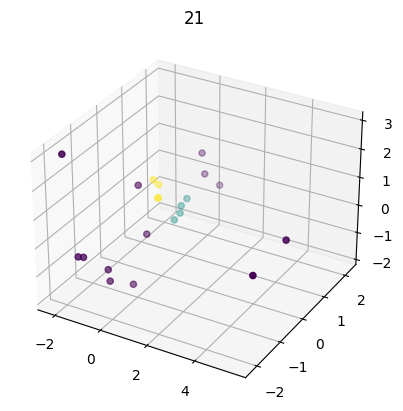

,0,STK,DrTP,VIN,DatKont,TZn,DrVoz,ObchOznTyp,Ct,DatPrvReg,...,Zav2,Zav3,Zav4,Zav5,Zav6,Zav7,Zav8,Zav9,StariDnu,RelKont
0,-1,3100,Evidenční kontrola,WDB9061311N376671,2020-01-15,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,SPRINTER,N1,2008-07-13,...,0,0,0,0,0,0,0,0,5295.0,0.0
1,-1,3100,Evidenční kontrola,WDB9061311N415449,2020-01-15,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,SPRINTER,N1,2009-05-04,...,0,0,0,0,0,0,0,0,5000.0,0.0
2,-1,3100,Evidenční kontrola,WDB9061351N625866,2020-01-16,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,SPRINTER,N1,2015-05-06,...,0,0,0,0,0,0,0,0,2807.0,1.0
3,-1,3100,Evidenční kontrola,WDF4156051U113488,2020-01-16,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,CITAN,N1,2013-07-11,...,0,0,0,0,0,0,0,0,3471.0,1.0
4,-1,3100,Evidenční kontrola,WDB9066371P358964,2020-01-16,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,SPRINTER 316 CDI,N1,2016-12-22,...,0,0,0,0,0,0,0,0,2211.0,1.0
5,1,3100,Evidenční kontrola,WDB9061351N632091,2020-01-20,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,SPRINTER 319 CDI,N1,2015-06-25,...,0,0,0,0,0,0,0,0,2757.0,5.0
6,0,3100,Evidenční kontrola,WDB96340610013594,2020-01-20,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,ACTROS 1845 LSNRL,N3,2015-10-22,...,0,0,0,0,0,0,0,0,2638.0,5.0
7,-1,3100,Evidenční kontrola,WDB9066351S586746,2020-01-20,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,SPRINTER,N1,2011-07-20,...,0,0,0,0,0,0,0,0,4193.0,5.0
8,1,3100,Evidenční kontrola,WDB9066371P163211,2020-01-20,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,SPRINTER 316 CDI,N1,2015-07-09,...,0,0,0,0,0,0,0,0,2743.0,5.0
9,0,3100,Evidenční kontrola,WDF9634061B993645,2020-01-20,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,ACTROS,N3,2018-04-24,...,0,0,0,0,0,0,0,0,1723.0,5.0


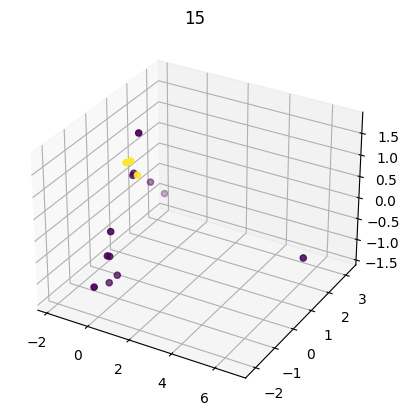

,0,STK,DrTP,VIN,DatKont,TZn,DrVoz,ObchOznTyp,Ct,DatPrvReg,...,Zav2,Zav3,Zav4,Zav5,Zav6,Zav7,Zav8,Zav9,StariDnu,RelKont
0,-1,3100,Evidenční kontrola,WDB9061331N622165,2020-01-23,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,SPRINTER,N1,2015-06-29,...,0,0,0,0,0,0,0,0,2753.0,1.0
1,0,3100,Evidenční kontrola,WDB9061351N655692,2020-01-23,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,SPRINTER 319 CDI,N1,2015-12-23,...,0,0,0,0,0,0,0,0,2576.0,1.0
2,-1,3100,Evidenční kontrola,WDB96340310121980,2020-01-27,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,ACTROS,N3,2017-03-01,...,0,0,0,0,0,0,0,0,2142.0,5.0
3,0,3100,Evidenční kontrola,WDB96340610179884,2020-01-28,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,ACTROS,N3,2017-08-22,...,0,0,0,0,0,0,0,0,1968.0,6.0
4,0,3100,Evidenční kontrola,WDB9076331P005460,2020-01-28,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,SPRINTER,N1,2018-06-11,...,0,0,0,0,0,0,0,0,1675.0,6.0
5,-1,3100,Evidenční kontrola,WDB9302021L048725,2020-02-03,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,ACTROS,N3,2005-09-14,...,0,0,0,0,0,0,0,0,6328.0,12.0
6,-1,3100,Evidenční kontrola,WDB6760671K184829,2020-02-03,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,OM366LAXXIII,N2,1996-01-01,...,0,0,0,0,0,0,0,0,9872.0,12.0
7,-1,3100,Evidenční kontrola,WDB9061331N584673,2020-02-03,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,SPRINTER 316 CDI,N1,2014-10-20,...,0,0,0,0,0,0,0,0,3005.0,12.0
8,-1,3100,Evidenční kontrola,WDB9066351S866936,2020-02-03,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,SPRINTER,N1,2014-04-14,...,0,0,0,0,0,0,0,0,3194.0,12.0
9,-1,3100,Evidenční kontrola,WDB9066351P358931,2020-02-05,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,SPRINTER,N1,2017-01-30,...,0,0,0,0,0,0,0,0,2172.0,14.0


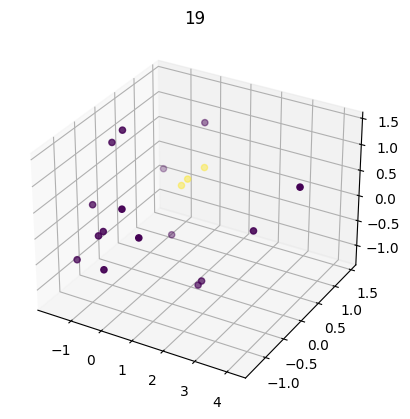

,0,STK,DrTP,VIN,DatKont,TZn,DrVoz,ObchOznTyp,Ct,DatPrvReg,...,Zav2,Zav3,Zav4,Zav5,Zav6,Zav7,Zav8,Zav9,StariDnu,RelKont
0,-1,3100,Evidenční kontrola,WDB9302021L048725,2020-02-03,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,ACTROS,N3,2005-09-14,...,0,0,0,0,0,0,0,0,6328.0,2.0
1,-1,3100,Evidenční kontrola,WDB6760671K184829,2020-02-03,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,OM366LAXXIII,N2,1996-01-01,...,0,0,0,0,0,0,0,0,9872.0,2.0
2,-1,3100,Evidenční kontrola,WDB9061331N584673,2020-02-03,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,SPRINTER 316 CDI,N1,2014-10-20,...,0,0,0,0,0,0,0,0,3005.0,2.0
3,-1,3100,Evidenční kontrola,WDB9066351S866936,2020-02-03,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,SPRINTER,N1,2014-04-14,...,0,0,0,0,0,0,0,0,3194.0,2.0
4,-1,3100,Evidenční kontrola,WDB9066351P358931,2020-02-05,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,SPRINTER,N1,2017-01-30,...,0,0,0,0,0,0,0,0,2172.0,4.0
5,0,3100,Evidenční kontrola,WDB96340610056286,2020-02-06,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,ACTROS 1848 LSNRL,N3,2016-04-13,...,0,0,0,0,0,0,0,0,2464.0,5.0
6,0,3100,Evidenční kontrola,WDC1641221A110863,2020-02-06,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,ML 320,N1G,2006-05-23,...,0,0,0,0,0,0,0,0,6077.0,5.0
7,0,3100,Evidenční kontrola,WDB96340610158408,2020-02-06,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,ACTROS 1848 LSNRL,N3,2017-04-18,...,0,0,0,0,0,0,0,0,2094.0,5.0
8,-1,3100,Evidenční kontrola,WDF4702311G015244,2020-02-07,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,X-KLASSE,N1G,2018-07-24,...,0,0,0,0,0,0,0,0,1632.0,6.0
9,-1,3100,Evidenční kontrola,WDB9630031L862824,2020-02-07,MERCEDES-BENZ,NÁKLADNÍ AUTOMOBIL,ACTROS,N3,2014-06-26,...,0,0,0,0,0,0,0,0,3121.0,6.0


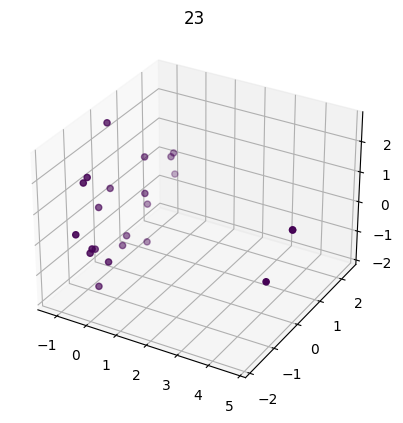

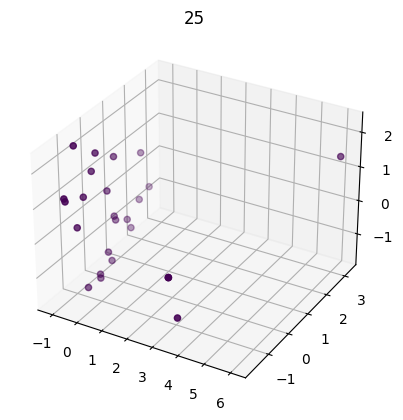

In [10]:
# clustering in the latent space
# dbscan

dbscan = DBSCAN(eps=0.5, min_samples=3)

i = 0
for group, time_windows in pca_transformed_df_grouped_time_windows.items():
    if time_windows:
        display(f'group {group}')
    
    for time_window_tuple in time_windows:
        time_window_orig = time_window_tuple[0]
        time_window = time_window_tuple[1]

        clusters = dbscan.fit(time_window)

        # 3D projection
        ax = plt.axes(projection ="3d")
        ax.scatter3D(time_window.iloc[:, 0], time_window.iloc[:, 1], time_window.iloc[:, 2],
            c=clusters.labels_)
        plt.title(len(time_window))
        plt.show()

        if len(np.unique(clusters.labels_)) > 1: # at least two clusters
            # for name, orig_df in df_groups[group].items():
            display(pd.concat([
                pd.DataFrame(np.array(clusters.labels_)).reset_index(drop=True),
                time_window_orig.iloc[time_window.index].reset_index(drop=True)],
                axis=1))

        # # 2D projection
        # plt.scatter(time_window.iloc[:, 0], time_window.iloc[:, 1], c=clusters.labels_)
        # plt.show()

        # display(clusters.labels_)

    i = i + 1
    if i > 7:
        break


## Autoencoder + DBSCAN

In [74]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

class MyDataset(Dataset):
    """Single PD DF dataset"""

    def __init__(self, df):
        self.df = df.astype('float32')

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self,idx):
        tensor = torch.tensor(self.df.iloc[idx])
        return tensor, torch.tensor(0).float()

class AE(nn.Module):
    def __init__(self, original_dim, encoding_dim):
        super(AE, self).__init__()

        mid_dim = (original_dim + encoding_dim) // 2

        self.name = f'ae-with-in-out-{original_dim}-{mid_dim}-{encoding_dim}'

        # input
        self.layer_input = nn.Linear(original_dim, mid_dim)
        # encoder
        self.layer_encoder = nn.Linear(mid_dim, encoding_dim)
        # decoder
        self.layer_decoder = nn.Linear(encoding_dim, mid_dim)
        # output
        self.layer_output = nn.Linear(mid_dim, original_dim)

    def forward(self, x):
        input = F.relu(self.layer_input(x))
        # pass input into encoder
        encoded = F.relu(self.layer_encoder(input))
        # pass encoded into decoder
        decoded = F.relu(self.layer_decoder(encoded))
        # pass to output
        return self.layer_output(decoded), encoded

def ae_encode(df, n_epochs):
    dataset = MyDataset(df)

    dataloader = torch.utils.data.DataLoader(dataset, 
                                          batch_size = 4,
                                          shuffle = True)
    
    original_dim = len(dataset.__getitem__(0)[0])
    latent_dim = 3
    model = AE(original_dim, latent_dim).to(device)

    # what are we going to optimize?
    criterion = nn.MSELoss() # if you have a regression task and don't know what to do - use `MSELoss`

    # how are we going to optimize it?
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # if you just don't know what to do - use `Adam` optimizer

    for epoch in range(1, n_epochs + 1):
        # monitor training loss
        train_loss = 0.0

        for data, _ in dataloader: # returns batch shape = (batch_size, 28, 28)
            optimizer.zero_grad() # clear the gradients of all optimized variables
            data = data.to(device) # send to GPU
            outputs, _ = model(data)  # forward pass: compute predicted outputs by passing inputs to the model
            loss = criterion(outputs, data) # calculate the loss
            loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
            optimizer.step() # perform a single optimization step (parameter update)
            train_loss += loss.item()
      
        train_loss_per = train_loss/len(dataloader)
        # print(f'    Epoch: {epoch} \tTraining Loss: {train_loss_per:.4f} ({train_loss})')

        if train_loss_per <= 0.005:
            break

    print(f'    Final Training Loss: {train_loss_per:.4f} ({train_loss})')
    
    
    # save the model
    # torch.save(model.state_dict(), f'{file_prefix}{name}.{model.name}.pth')

    # evaluate
    model.eval()

    encoded_dataset = []
    for i in range(len(dataset)):
        X = dataset[i][0].to(device)
        with torch.no_grad():
            _, encoded = model(X)
        encoded = encoded.cpu()
        # torch.Tensor.cpu()
        encoded_dataset.append(encoded.numpy())

    return pd.DataFrame(np.array(encoded_dataset), index=df.index)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# autoencoder on the individual time windows

ae_indiv_transformed_df_grouped_time_windows = {}

scaler = StandardScaler()

for group, time_windows in df_grouped_time_windows.items():
    print(group)

    transformed_time_windows = []

    for time_window in time_windows:

        # smaller groups than 7 vehicles will be assessed using a handwritten heuristic
        if len(time_window) < 7:
            continue

        # drop unneeded features
        trans_df = time_window[['Km', 'VyslSTK', 'DTKont', 'ZavA', 'ZavB',
       'ZavC', 'Zav0', 'Zav1', 'Zav2', 'Zav3', 'Zav4', 'Zav5', 'Zav6', 'Zav7',
       'Zav8', 'Zav9', 'StariDnu', 'RelKont']]

        # convert `Ct` to dummies (is this feature needed?)
        # dummies = pd.get_dummies(trans_df[['Ct']], drop_first=True)
        # trans_df = pd.concat([trans_df, dummies], axis=1)

        # scale features
        trans_df = scaler.fit_transform(trans_df.to_numpy())
        trans_df = pd.DataFrame(trans_df, columns=['Km', 'VyslSTK', 'DTKont', 'ZavA', 'ZavB',
       'ZavC', 'Zav0', 'Zav1', 'Zav2', 'Zav3', 'Zav4', 'Zav5', 'Zav6', 'Zav7',
       'Zav8', 'Zav9', 'StariDnu', 'RelKont'])

        # transform using AE
        # display(f'  Time window {trans_df.head(1)}')
        trans_df = ae_encode(trans_df, 1000) # use many epochs as we have very little data points avaliable
        display(trans_df)
        
        transformed_time_windows.append((time_window, trans_df.copy(deep=True)))

        break

    pca_transformed_df_grouped_time_windows[group] = transformed_time_windows

In [ ]:
# save the results
import pickle
with open(f'{file_prefix}pca_transformed_df_grouped_time_windows.pickle', 'wb') as file:
    pickle.dump(pca_transformed_df_grouped_time_windows, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# clustering in the latent space